# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [1]:
# disable gpu
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


## Uncomment w
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import glob

In [4]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [5]:
RATIO_TO_PREDICT = "BTC-USD"
FUTURE_PERIOD_PREDICT = 1

## Loading data

#### Downloaded data
I downloaded dataset from: https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip. It contains 4 separate files with 5 columns for BTC, LTC, ETH and BCH. I am going to use only close price column. Code below extracts mecessary data from those files and creates pandas dataframe from it.

This code loops through ratios and loads the whole file into dataframe. Before adding that dataframe to our main dataframe which is called main_df we will drop unnecessary and only keep close price.

In [6]:
main_df = pd.DataFrame()

ratios = ["BTC-USD", "LTC-USD","ETH-USD","BCH-USD"]

for ratio in ratios:
    dataset = "crypto_data/"+ratio+".csv"
    df = pd.read_csv(dataset, names=["time","low","high","open","close","volume"])
    
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)
    
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close"]]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)


In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97724 entries, 1528968660 to 1535215200
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  97724 non-null  float64
 1   LTC-USD_close  96495 non-null  float64
 2   ETH-USD_close  97422 non-null  float64
 3   BCH-USD_close  87103 non-null  float64
dtypes: float64(4)
memory usage: 6.2 MB


In [8]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,97724.000000,96495.000000,97422.000000,87103.000000
mean,6773.521546,77.699971,424.308210,723.205108
std,641.354134,12.689494,75.786805,111.495463
min,5778.109863,49.560001,251.000000,473.209991
25%,6341.470215,74.010002,407.059998,686.750000
50%,6536.375000,80.680000,451.450012,742.380005
75%,7286.490112,84.730003,472.070007,810.404999
max,8482.799805,103.040001,547.000000,927.000000


Because there are some NaN values we will get rid of them using code below.

In [9]:
main_df = main_df.dropna()

Here we can see how main_df. It contains 5 columns from which we will be using only close prices.

In [10]:
main_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
1528968720,6487.379883,96.660004,486.010010,870.859985
1528968780,6479.410156,96.570000,486.000000,870.099976
1528968840,6479.410156,96.500000,485.750000,870.789978
1528968900,6479.979980,96.389999,486.000000,870.000000
1528968960,6480.000000,96.519997,486.000000,869.989990
...,...,...,...,...
1535214960,6713.140137,58.020000,279.359985,531.479980
1535215020,6714.520020,58.009998,279.359985,531.479980
1535215080,6714.520020,58.020000,279.369995,531.469971


In [11]:
main_df.index = pd.to_datetime(main_df.index,unit='s')

In [12]:
main_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
2018-06-14 09:32:00,6487.379883,96.660004,486.010010,870.859985
2018-06-14 09:33:00,6479.410156,96.570000,486.000000,870.099976
2018-06-14 09:34:00,6479.410156,96.500000,485.750000,870.789978
2018-06-14 09:35:00,6479.979980,96.389999,486.000000,870.000000
2018-06-14 09:36:00,6480.000000,96.519997,486.000000,869.989990
...,...,...,...,...
2018-08-25 16:36:00,6713.140137,58.020000,279.359985,531.479980
2018-08-25 16:37:00,6714.520020,58.009998,279.359985,531.479980
2018-08-25 16:38:00,6714.520020,58.020000,279.369995,531.469971


To have better idea what our main dataframe represents we can plot our 4 prices using matplotlib

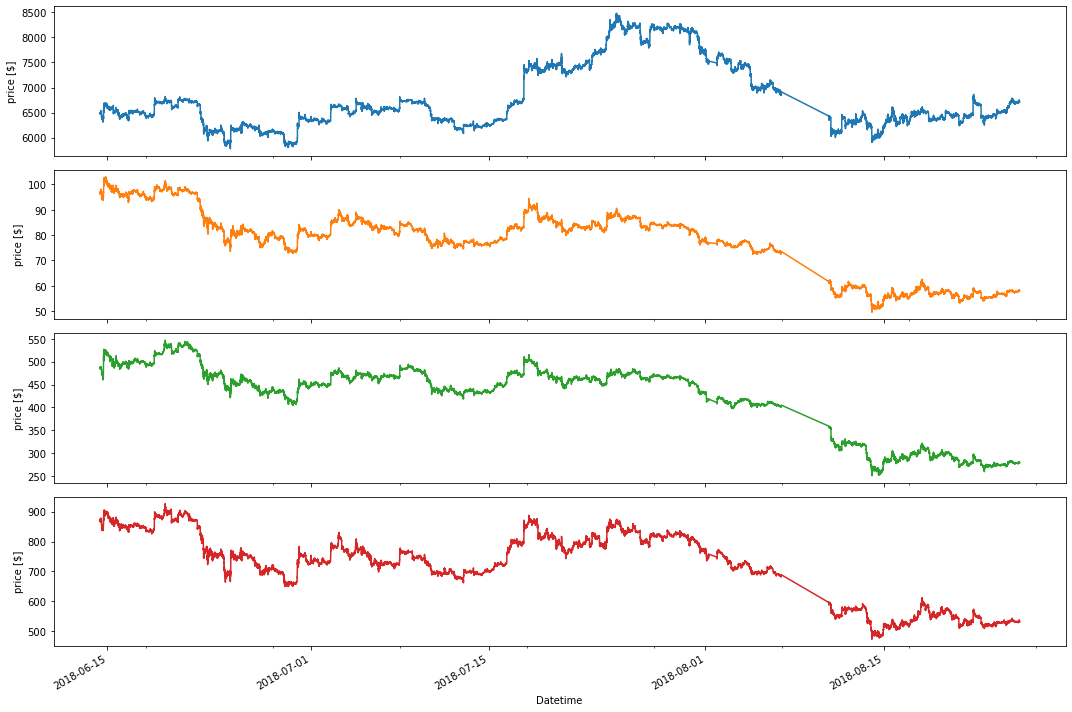

In [13]:
main_df.plot(subplots=True, legend = False, xlabel="Datetime", ylabel="price [$]")
plt.tight_layout()
plt.show()

As we can see, there is a problematic part in our df in two thirds of the lenght.
I will cut the dataframe to exclude that data.

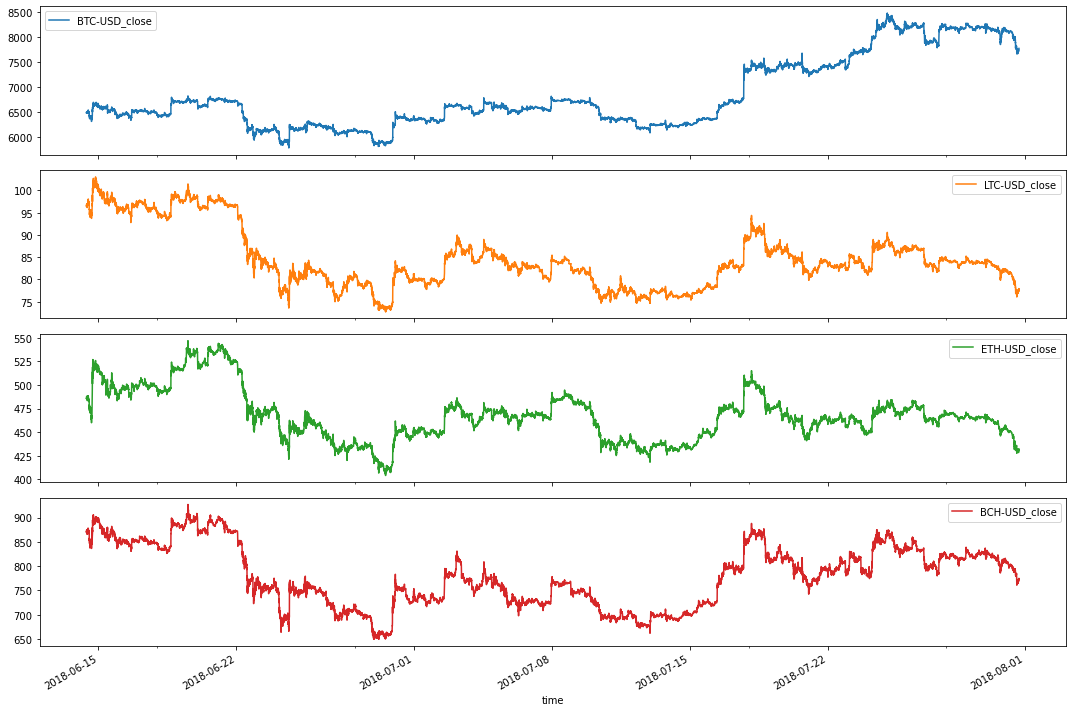

In [14]:
n = int(len(main_df)*0.70)
main_df = main_df[:n]
main_df.plot(subplots=True)
plt.tight_layout()
plt.show()

Another very useful function to use when exploring datasets is describe().

In [15]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,60281.000000,60281.000000,60281.000000,60281.000000
mean,6820.147480,84.659846,467.844925,780.026503
std,698.026359,6.660242,26.888865,63.047975
min,5778.109863,72.760002,404.220001,649.619995
25%,6330.399902,80.059998,449.600006,726.739990
50%,6591.540039,83.339996,466.250000,777.140015
75%,7374.970215,87.010002,478.700012,831.000000
max,8482.799805,103.040001,547.000000,927.000000


Some more info with .info()

In [16]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60281 entries, 2018-06-14 09:32:00 to 2018-07-31 16:39:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  60281 non-null  float64
 1   LTC-USD_close  60281 non-null  float64
 2   ETH-USD_close  60281 non-null  float64
 3   BCH-USD_close  60281 non-null  float64
dtypes: float64(4)
memory usage: 2.3 MB


#### Created data

This part explores data  I have been collecting.

In [187]:
path = 'crypto_data/my_dataset_csv.csv'               

my_df = pd.read_csv(path, index_col="Datetime", parse_dates=True)  
my_df.fillna(method="ffill", inplace=True)

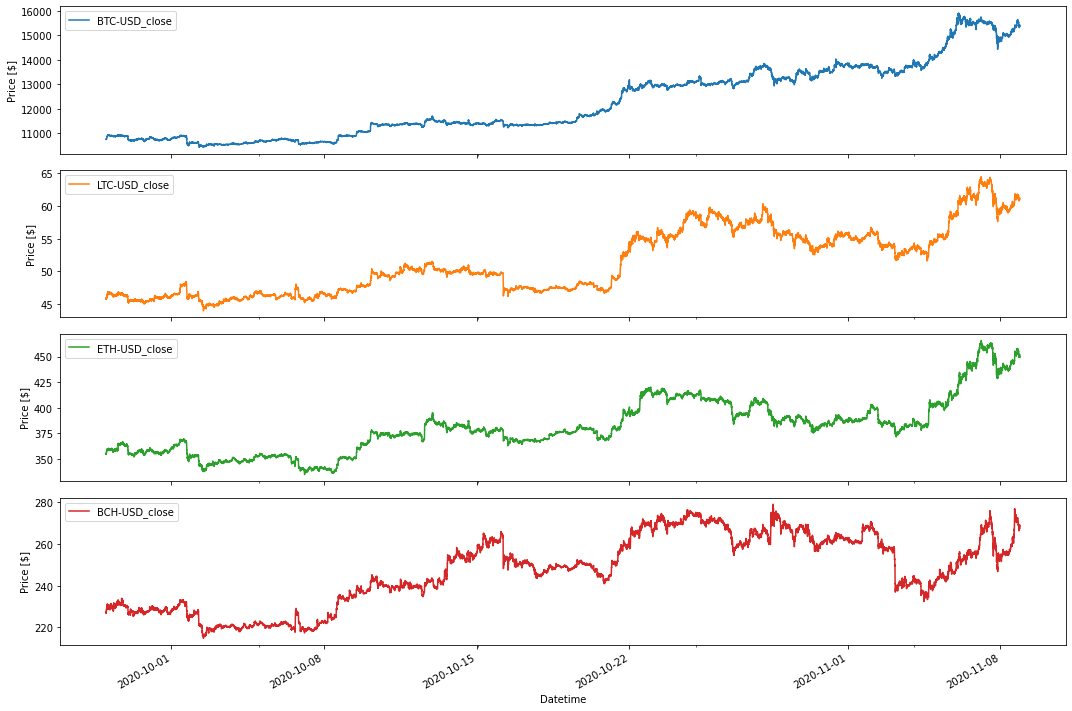

In [188]:
my_df.plot(subplots=True, ylabel="Price [$]")
plt.tight_layout()
plt.show()

In [176]:
my_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
Datetime,,,,
2020-09-28 00:01:00+01:00,-3.440834e-05,-3.247676e-04,2.131614e-04,0.000144
2020-09-28 00:02:00+01:00,5.510991e-05,1.563742e-03,-6.272946e-06,-0.000055
2020-09-28 00:03:00+01:00,1.614143e-04,-1.710300e-03,4.338832e-04,0.000246
2020-09-28 00:04:00+01:00,-1.800876e-04,-2.564821e-04,2.456653e-05,-0.000793
2020-09-28 00:05:00+01:00,-3.912812e-05,1.592956e-03,-4.940688e-04,0.000034
...,...,...,...,...
2020-11-08 20:33:00+00:00,-4.894312e-06,-1.932480e-05,-8.656488e-05,-0.000014
2020-11-08 20:34:00+00:00,-3.114826e-05,-2.264613e-04,1.839324e-04,0.000151
2020-11-08 20:35:00+00:00,3.176633e-07,5.004818e-07,-1.355904e-07,0.000000


In [19]:
#my_df = my_df.drop('Datetime', 1)

In [20]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58393 entries, 2020-09-28 00:00:00+01:00 to 2020-11-08 20:37:00+00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  58393 non-null  float64
 1   LTC-USD_close  58393 non-null  float64
 2   ETH-USD_close  58393 non-null  float64
 3   BCH-USD_close  58393 non-null  float64
dtypes: float64(4)
memory usage: 2.2+ MB


In [21]:
my_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,58393.000000,58393.000000,58393.000000,58393.000000
mean,12268.990620,51.514071,381.585928,247.550386
std,1457.786256,4.955799,26.543030,16.886831
min,10440.311520,44.019604,334.545563,214.629974
25%,10901.831050,46.996445,363.054962,233.423035
50%,11552.742190,50.106308,379.235748,249.369400
75%,13433.404300,55.417450,394.844269,261.914581
max,15903.437500,64.402084,465.675476,279.121887


#### Convert to percentage change

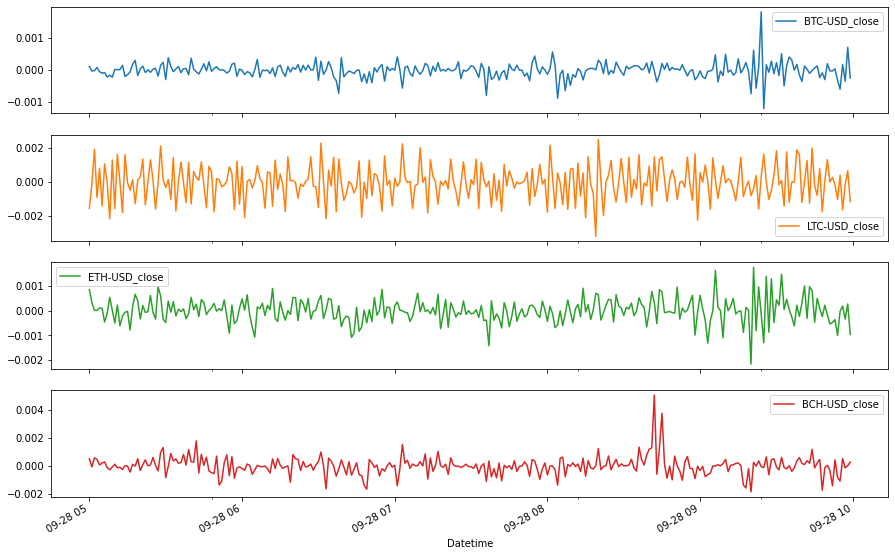

In [22]:
my_df = my_df.pct_change().copy() 
my_df[300:600].plot(subplots=True)
my_df = my_df[1:]
plt.show()

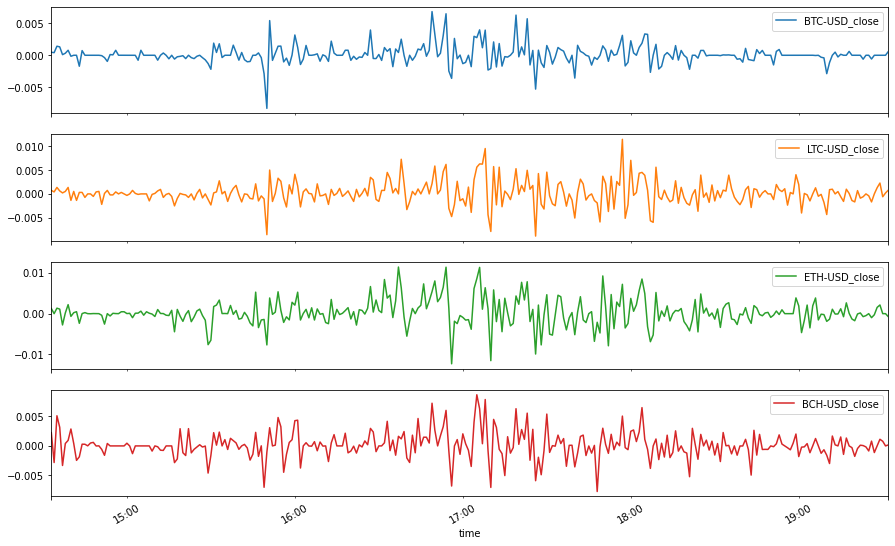

In [23]:
main_df = main_df.pct_change().copy() 
main_df[300:600].plot(subplots=True)
main_df = main_df[1:]
plt.show()

## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [24]:
def split_dataset(df):
    
    """
    Function returns train, validation and test dataframes. In ratio 70:20:10.

    Parameters
    ----------
    df: DataFrame
        DataFrame we would like to split

    Returns
    ----------
    Three dataframes.
    """
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [25]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [26]:
train_df_d, val_df_d, test_df_d = split_dataset(main_df)

In [178]:
train_df_my, val_df_my, test_df_my = split_dataset(my_df)

## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it.

##### Z-score

In [28]:
import joblib
from sklearn.preprocessing import StandardScaler
scaler_d = StandardScaler()  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = test_df_d.columns)


#scaler_my = StandardScaler()
my_scaler_loaded = joblib.load('scalers/scaler_my_pct.gz') # load scaler

train_df_my = pd.DataFrame(my_scaler_loaded.transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(my_scaler_loaded.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(my_scaler_loaded.transform(test_df_my),columns = test_df_my.columns)
""" 
scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
"""

C:\Users\Admin\anaconda3\envs\nwmGPU\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


' \nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n'

##### Min-max scaler.

In [29]:
"""
from sklearn.preprocessing import MinMaxScaler


scaler_d_min_max = MinMaxScaler()

train_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)


scaler_my_min_max = MinMaxScaler()

train_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n\n\nscaler_d_min_max = MinMaxScaler()\n\ntrain_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)\nval_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)\ntest_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)\n\n\nscaler_my_min_max = MinMaxScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)\n'

### Data windowing

Models will make predictions using part of data called windows. 


In [30]:
class WindowGenerator():
    
    """
    Moving window class. Contains needed dataframes for training. 

    Parameters
    ----------
    input_width: int
        Dataframe we would like to split.
        
    input_width: int
        Width of window part model is supposed to predict.
        
    shift: int
        Shift between input and label.
        
    train_df: DataFrame
        Training dataframe
        
    val_df: DataFrame
        Validation dataframe
        
    test_df: DataFrame
        Test dataframe
    
    label_columns: 
        label column indices
    """
    
    
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [31]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :] 
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [32]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=1,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=['BTC-USD_close'])
w2


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['BTC-USD_close']

In [33]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])


In [34]:

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 25, 4)
Inputs shape: (3, 24, 4)
labels shape: (3, 1, 1)


Simple vizualization of the split window with function plot().

In [35]:
w2.example = example_inputs, example_labels

In [36]:
def plot(self, model=None, plot_col=RATIO_TO_PREDICT+'_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs) # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-tensorflow
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [37]:
def plot_input_data(self,  model=None):
    inputs, labels = self.example
    
    print(inputs)
    plot(inputs)
    
WindowGenerator.plot_input_data = plot_input_data

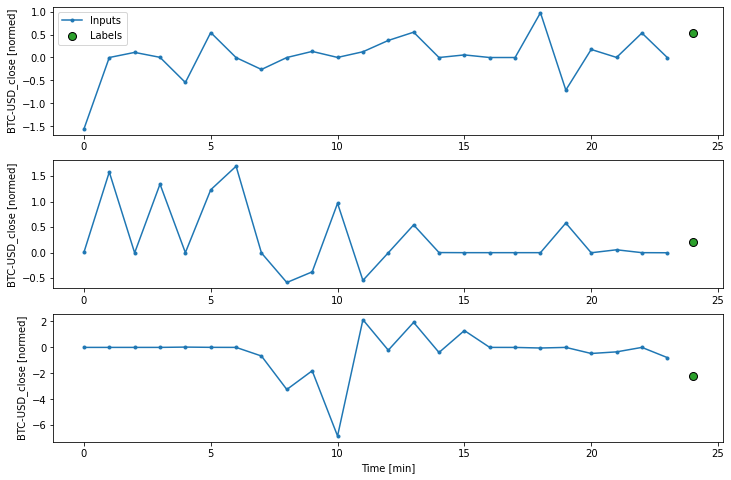

In [38]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [39]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
      # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [40]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [41]:
wide_window_d = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

In [42]:
wide_window_my = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])

#### To compare prediction performances

In [43]:
val_performance = {}
performance = {}

## Models

MyModel class to make working with models easier. 

In [44]:
from tensorflow.keras.models import load_model

class MyModel():
    
    def __init__(self, model):
        self.model = model
        
    def load_model(self, dir_name):
        self.model = load_model(dir_name)
    
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("models_pct\\models_28_04_2021\\"+ name +".model")
        
    def retrain_model(self, window, patience, epochs):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        
    def compile_and_fit(self, window, patience=3, epochs=120):

        ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min', restore_best_weights=True)
        
        # https://github.com/Jaewan-Yun/optimizer-visualization
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        opt = tf.optimizers.Adam(learning_rate=0.02)
        
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=opt,
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = self.model.fit(window.train, epochs=epochs,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history

#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

To plot learning process there is a function below.

In [45]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

To save model I created function below.

In [46]:
k

NameError: name 'k' is not defined

### Recurrent neural network (LSTM)

[batch, timesteps, feature] 3D input

In [47]:
act = "tanh"
recurrent_act = "sigmoid"

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [48]:
lstm = MyModel(lstm_model)

In [49]:
history = lstm.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 14s 8ms/step - loss: 0.9236 - mean_absolute_error: 0.4610 - val_loss: 1.2952 - val_mean_absolute_error: 0.5995
Epoch 2/120
1318/1318 [==============================] - 11s 8ms/step - loss: 0.7911 - mean_absolute_error: 0.4472 - val_loss: 1.3570 - val_mean_absolute_error: 0.6072
Epoch 3/120
1318/1318 [==============================] - 10s 8ms/step - loss: 0.7188 - mean_absolute_error: 0.4371 - val_loss: 1.3890 - val_mean_absolute_error: 0.6208
Epoch 4/120
1318/1318 [==============================] - 10s 8ms/step - loss: 0.6679 - mean_absolute_error: 0.4293 - val_loss: 1.3447 - val_mean_absolute_error: 0.6140


In [50]:
val_performance['LSTM'] = lstm.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM'] = lstm.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 2s 4ms/step - loss: 1.2952 - mean_absolute_error: 0.5995
Loss: 1.2951606512069702 MAE: 0.5994835495948792
188/188 [==============================] - 1s 4ms/step - loss: 1.0116 - mean_absolute_error: 0.4808
Loss: 1.011647343635559 MAE: 0.4808056056499481


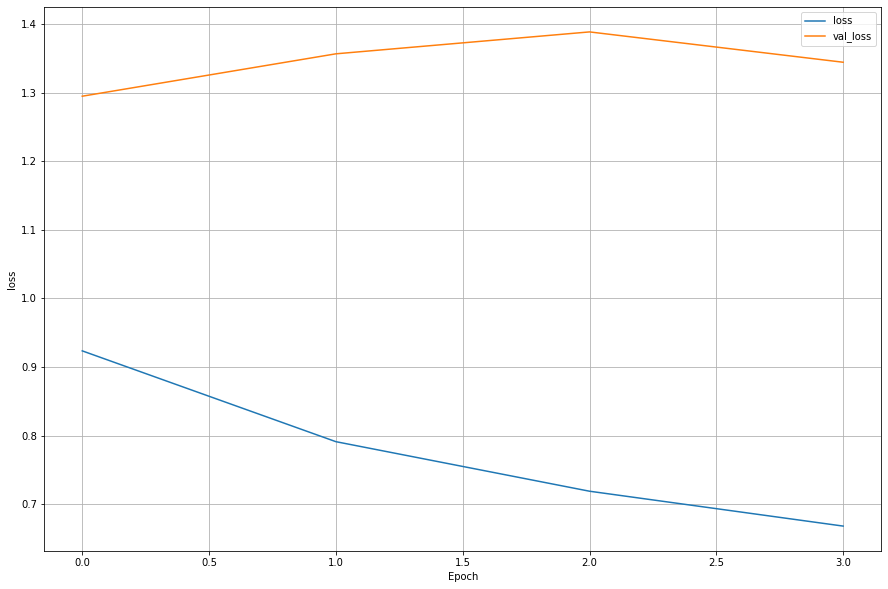

In [51]:
plot_loss(history, 'loss')

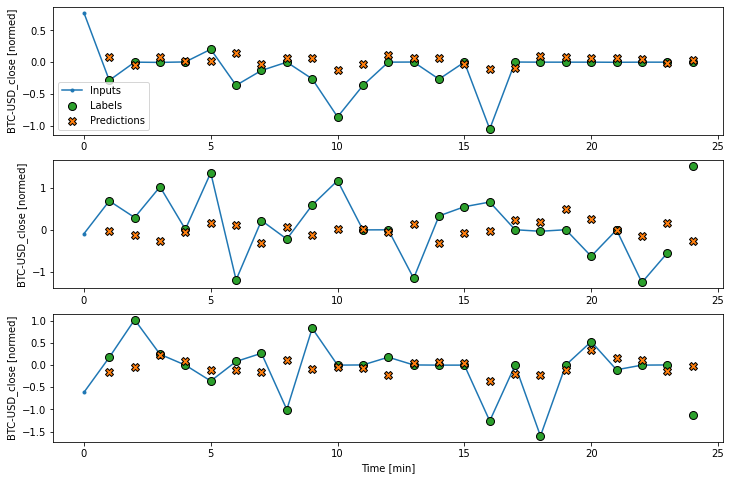

In [52]:
wide_window_d.plot(lstm.model)

In [53]:
lstm.save_model("lstm")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm.model\assets


#### Loading model

In [54]:
lstm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 32)            4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 32)            8320      
_________________________________________________________________
dense (Dense)                (None, 24, 1)             33        
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [55]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [56]:
lstm_bidi = MyModel(lstm_model_bidirectional)

In [57]:
history = lstm_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 20s 13ms/step - loss: 0.0724 - mean_absolute_error: 0.0838 - val_loss: 0.0653 - val_mean_absolute_error: 0.0656
Epoch 2/120
1318/1318 [==============================] - 17s 13ms/step - loss: 0.0482 - mean_absolute_error: 0.0543 - val_loss: 0.0727 - val_mean_absolute_error: 0.0752
Epoch 3/120
1318/1318 [==============================] - 18s 13ms/step - loss: 0.0460 - mean_absolute_error: 0.0489 - val_loss: 0.0637 - val_mean_absolute_error: 0.0603
Epoch 4/120
1318/1318 [==============================] - 17s 13ms/step - loss: 0.0447 - mean_absolute_error: 0.0459 - val_loss: 0.0607 - val_mean_absolute_error: 0.0501
Epoch 5/120
1318/1318 [==============================] - 17s 13ms/step - loss: 0.0446 - mean_absolute_error: 0.0449 - val_loss: 0.0620 - val_mean_absolute_error: 0.0577
Epoch 6/120
1318/1318 [==============================] - 17s 13ms/step - loss: 0.0437 - mean_absolute_error: 0.0427 - val_loss: 0.0610 - val_mean_absolute_

In [58]:
val_performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 3s 7ms/step - loss: 0.0607 - mean_absolute_error: 0.0501
Loss: 0.0606643408536911 MAE: 0.05007487162947655
188/188 [==============================] - 1s 7ms/step - loss: 0.0422 - mean_absolute_error: 0.0408
Loss: 0.04222767800092697 MAE: 0.04077141731977463


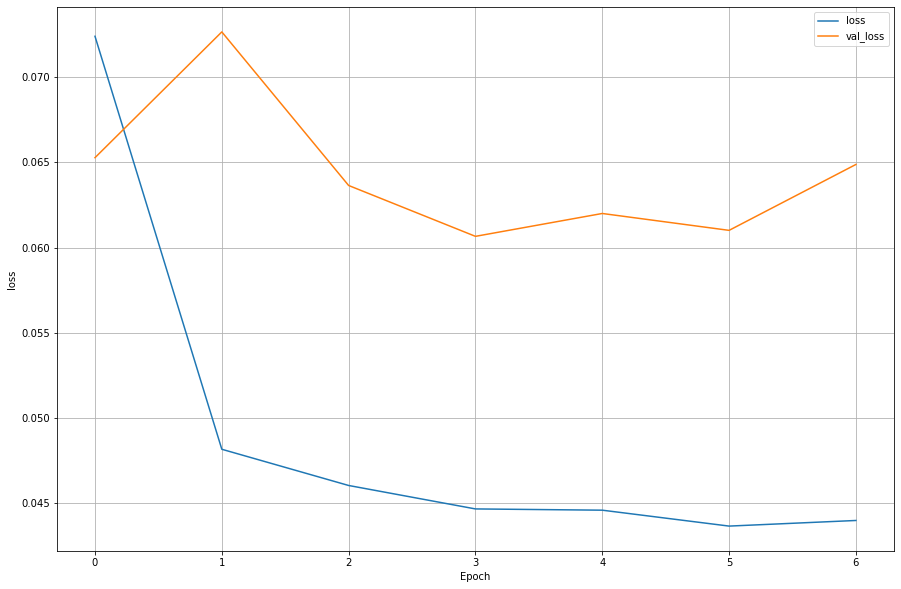

In [59]:
plot_loss(history, 'loss')

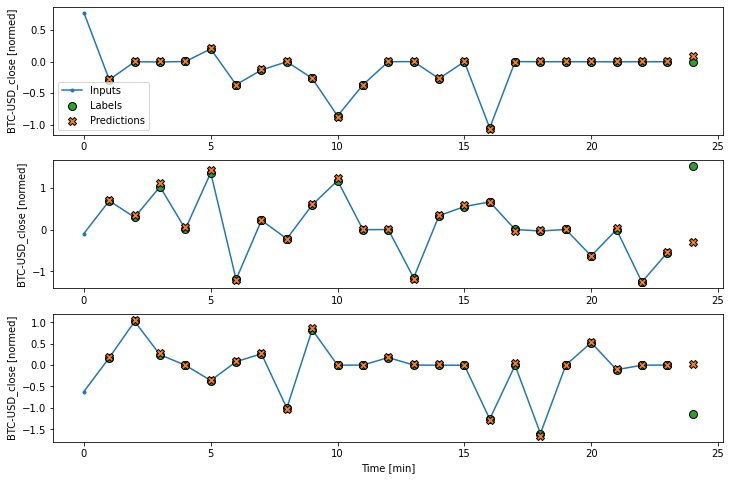

In [60]:
wide_window_d.plot(lstm_bidi.model)

In [61]:
lstm_bidi.save_model("l_bidi")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_bidi.model\assets


### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [62]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])


In [63]:
gru = MyModel(gru_model)

In [64]:
history = gru.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 10s 7ms/step - loss: 0.9633 - mean_absolute_error: 0.4678 - val_loss: 1.2813 - val_mean_absolute_error: 0.5921
Epoch 2/120
1318/1318 [==============================] - 8s 6ms/step - loss: 0.9563 - mean_absolute_error: 0.4667 - val_loss: 1.2997 - val_mean_absolute_error: 0.5950
Epoch 3/120
1318/1318 [==============================] - 8s 6ms/step - loss: 0.9492 - mean_absolute_error: 0.4628 - val_loss: 1.2751 - val_mean_absolute_error: 0.5909
Epoch 4/120
1318/1318 [==============================] - 8s 6ms/step - loss: 0.9502 - mean_absolute_error: 0.4637 - val_loss: 1.2994 - val_mean_absolute_error: 0.5941
Epoch 5/120
1318/1318 [==============================] - 8s 6ms/step - loss: 0.9537 - mean_absolute_error: 0.4636 - val_loss: 1.2818 - val_mean_absolute_error: 0.5881
Epoch 6/120
1318/1318 [==============================] - 8s 6ms/step - loss: 0.9625 - mean_absolute_error: 0.4656 - val_loss: 1.2729 - val_mean_absolute_error: 0.59

In [65]:
val_performance['GRU'] = gru.eval_mod(wide_window_d.val, verbose=1)
performance['GRU'] = gru.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 1s 3ms/step - loss: 1.2729 - mean_absolute_error: 0.5909
Loss: 1.2729026079177856 MAE: 0.5909074544906616
188/188 [==============================] - 1s 3ms/step - loss: 0.9656 - mean_absolute_error: 0.4709
Loss: 0.9655978083610535 MAE: 0.4709228575229645


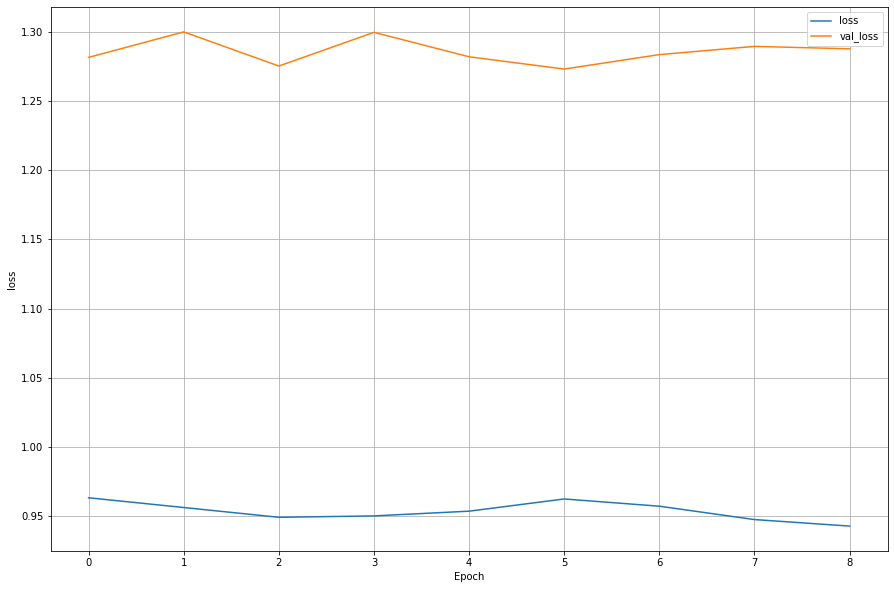

In [66]:
plot_loss(history, 'loss')

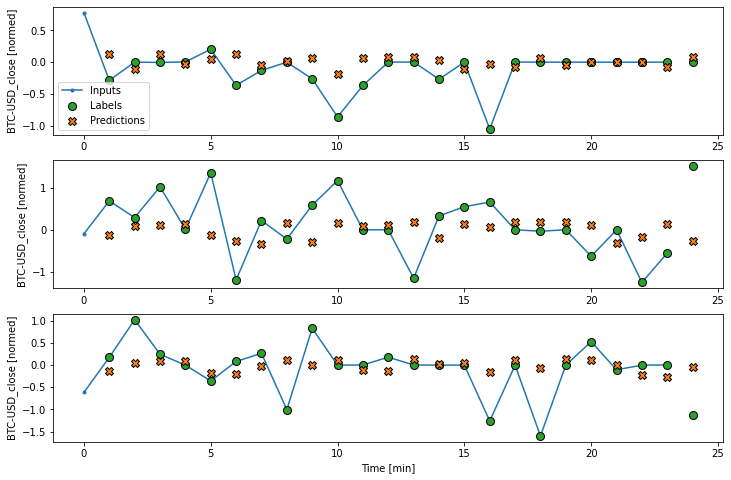

In [67]:
wide_window_d.plot(gru.model)

In [68]:
gru.save_model("gru")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru.model\assets


### Recurrent neural network (GRU - bidirectional)

In [69]:
gru_model_bidirectional = tf.keras.models.Sequential([

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=rec_a)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=rec_a)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=rec_a)),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [70]:
gru_bidi = MyModel(gru_model_bidirectional)

In [71]:
history = gru_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 17s 10ms/step - loss: 0.0884 - mean_absolute_error: 0.1099 - val_loss: 0.0907 - val_mean_absolute_error: 0.1029
Epoch 2/120
1318/1318 [==============================] - 13s 10ms/step - loss: 0.0806 - mean_absolute_error: 0.1035 - val_loss: 0.1505 - val_mean_absolute_error: 0.1482
Epoch 3/120
1318/1318 [==============================] - 13s 10ms/step - loss: 0.0713 - mean_absolute_error: 0.0946 - val_loss: 0.0784 - val_mean_absolute_error: 0.0842
Epoch 4/120
1318/1318 [==============================] - 13s 10ms/step - loss: 0.0565 - mean_absolute_error: 0.0723 - val_loss: 0.1091 - val_mean_absolute_error: 0.1446
Epoch 5/120
1318/1318 [==============================] - 13s 10ms/step - loss: 0.0620 - mean_absolute_error: 0.0791 - val_loss: 0.0714 - val_mean_absolute_error: 0.0805
Epoch 6/120
1318/1318 [==============================] - 13s 10ms/step - loss: 0.0525 - mean_absolute_error: 0.0629 - val_loss: 0.0723 - val_mean_absolute_

In [72]:
val_performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 1s 4ms/step - loss: 0.0714 - mean_absolute_error: 0.0805
Loss: 0.07136018574237823 MAE: 0.08051326870918274
188/188 [==============================] - 1s 4ms/step - loss: 0.0484 - mean_absolute_error: 0.0708
Loss: 0.048362717032432556 MAE: 0.07081787288188934


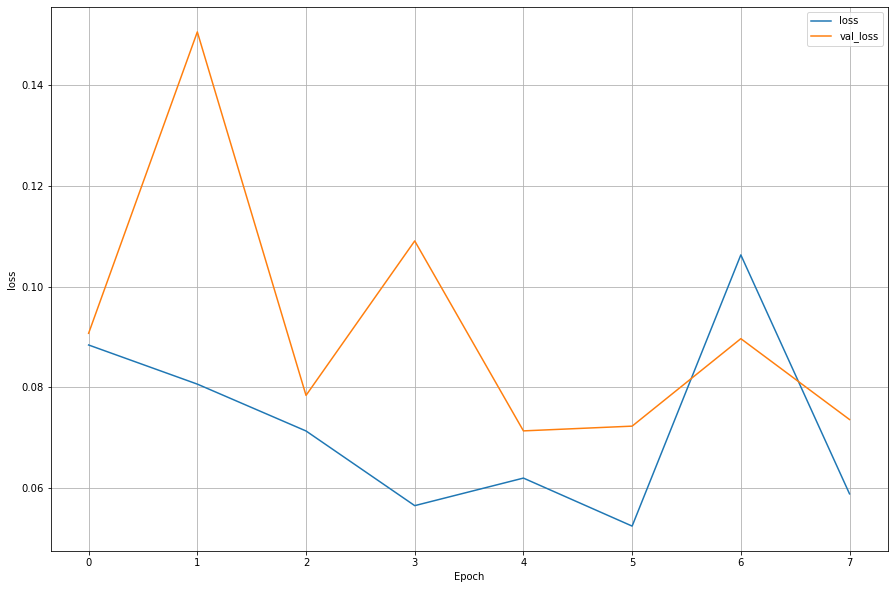

In [73]:
plot_loss(history, 'loss')

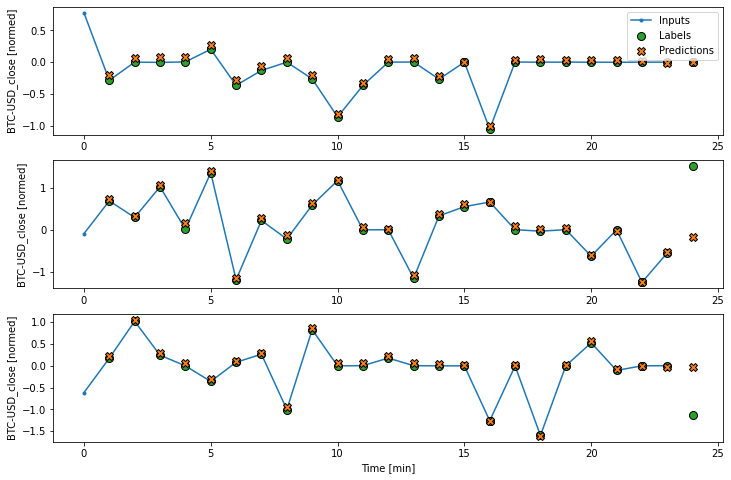

In [74]:
wide_window_d.plot(gru_bidi.model)

In [75]:
gru_bidi.save_model("g_bidi")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_bidi.model\assets


### Performance

In [76]:
"""
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
"""

"\nx = np.arange(len(performance))\nwidth = 0.3\nmetric_name = 'mean_absolute_error'\nmetric_index = lstm_model.metrics_names.index('mean_absolute_error')\nval_mae = [v[metric_index] for v in val_performance.values()]\ntest_mae = [v[metric_index] for v in performance.values()]\n\n\nplt.ylabel('mean_absolute_error [BTC-USD, normalized]')\nplt.bar(x - 0.17, val_mae, width, label='Validation')\nplt.bar(x + 0.17, test_mae, width, label='Test')\nplt.xticks(ticks=x, labels=performance.keys(),\n           rotation=45)\n_ = plt.legend()\n"

In [77]:
"""
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')
"""

"\nfor name, value in performance.items():\n    print(f'{name:12s}: {value[1]:0.4f}')\n"

## Single shot models
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [78]:
OUT_STEPS = 1
wide_window_d_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

wide_window_my_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])



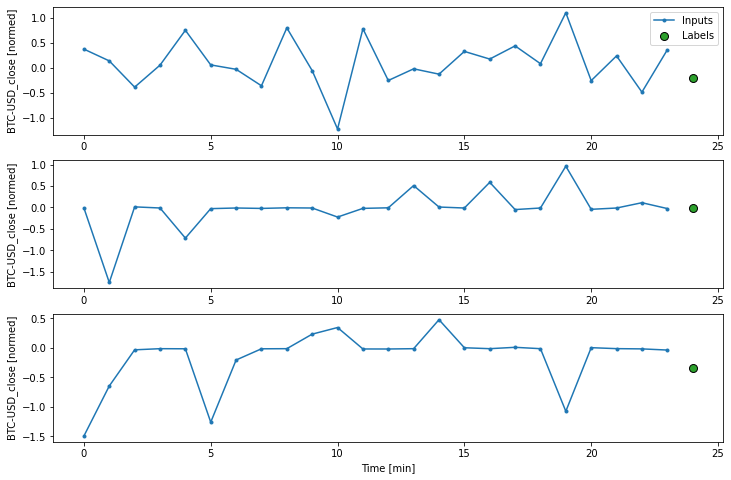

In [79]:
wide_window_my_single.plot()

In [80]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [81]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.LSTM(256, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])

In [82]:
lstm_single = MyModel(lstm_model_single)

In [83]:
history = lstm_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 11s 7ms/step - loss: 1.0025 - mean_absolute_error: 0.4466 - val_loss: 1.2929 - val_mean_absolute_error: 0.5788
Epoch 2/120
1318/1318 [==============================] - 9s 7ms/step - loss: 1.0020 - mean_absolute_error: 0.4441 - val_loss: 1.2931 - val_mean_absolute_error: 0.5803
Epoch 3/120
1318/1318 [==============================] - 9s 7ms/step - loss: 1.0020 - mean_absolute_error: 0.4462 - val_loss: 1.2930 - val_mean_absolute_error: 0.5798
Epoch 4/120
1318/1318 [==============================] - 9s 7ms/step - loss: 1.0018 - mean_absolute_error: 0.4444 - val_loss: 1.2927 - val_mean_absolute_error: 0.5749
Epoch 5/120
1318/1318 [==============================] - 9s 7ms/step - loss: 1.0020 - mean_absolute_error: 0.4451 - val_loss: 1.2935 - val_mean_absolute_error: 0.5834
Epoch 6/120
1318/1318 [==============================] - 9s 7ms/step - loss: 1.0021 - mean_absolute_error: 0.4447 - val_loss: 1.2936 - val_mean_absolute_error: 0.58

In [84]:
single_val_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 2s 4ms/step - loss: 1.2927 - mean_absolute_error: 0.5749
Loss: 1.2926892042160034 MAE: 0.5749314427375793
188/188 [==============================] - 1s 4ms/step - loss: 0.9807 - mean_absolute_error: 0.4477
Loss: 0.9806919097900391 MAE: 0.44770801067352295


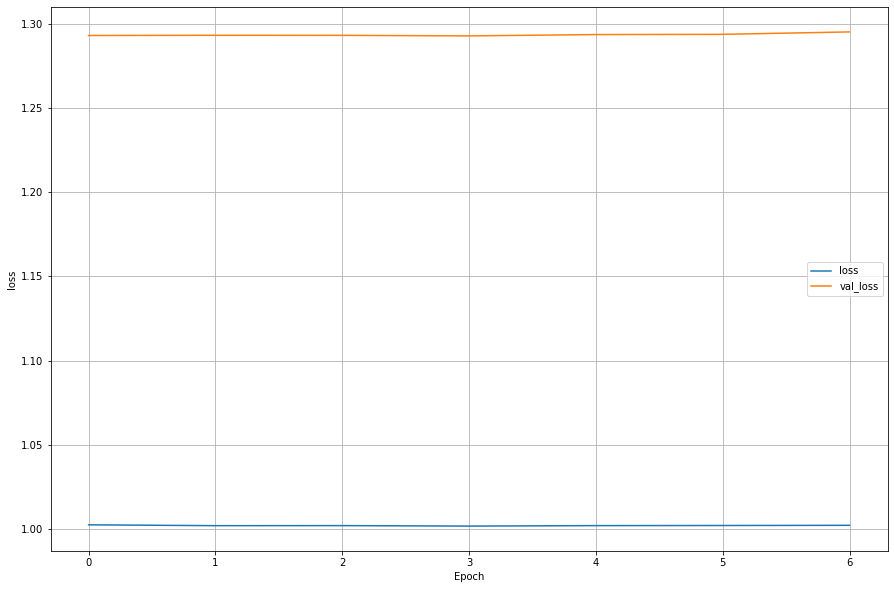

In [85]:
plot_loss(history, 'loss')

In [86]:
lstm_single.save_model("lstm_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm_s.model\assets


### LSTM Bidirectional single shot

In [87]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=rec_a)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(units=1)
])

In [88]:
lstm_bidi_single = MyModel(lstm_model_bidirectional_single)

In [89]:
history = lstm_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 17s 11ms/step - loss: 0.9999 - mean_absolute_error: 0.4791 - val_loss: 1.2685 - val_mean_absolute_error: 0.5905
Epoch 2/120
1318/1318 [==============================] - 14s 11ms/step - loss: 0.9890 - mean_absolute_error: 0.4636 - val_loss: 1.2657 - val_mean_absolute_error: 0.5858
Epoch 3/120
1318/1318 [==============================] - 14s 10ms/step - loss: 0.9868 - mean_absolute_error: 0.4608 - val_loss: 1.3120 - val_mean_absolute_error: 0.6311
Epoch 4/120
1318/1318 [==============================] - 14s 10ms/step - loss: 0.9868 - mean_absolute_error: 0.4644 - val_loss: 1.2708 - val_mean_absolute_error: 0.6006
Epoch 5/120
1318/1318 [==============================] - 14s 10ms/step - loss: 0.9861 - mean_absolute_error: 0.4688 - val_loss: 1.2714 - val_mean_absolute_error: 0.6032


In [90]:
single_val_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 2s 5ms/step - loss: 1.2657 - mean_absolute_error: 0.5858
Loss: 1.2656675577163696 MAE: 0.5857506394386292
188/188 [==============================] - 1s 5ms/step - loss: 0.9576 - mean_absolute_error: 0.4608
Loss: 0.9576226472854614 MAE: 0.4608460068702698


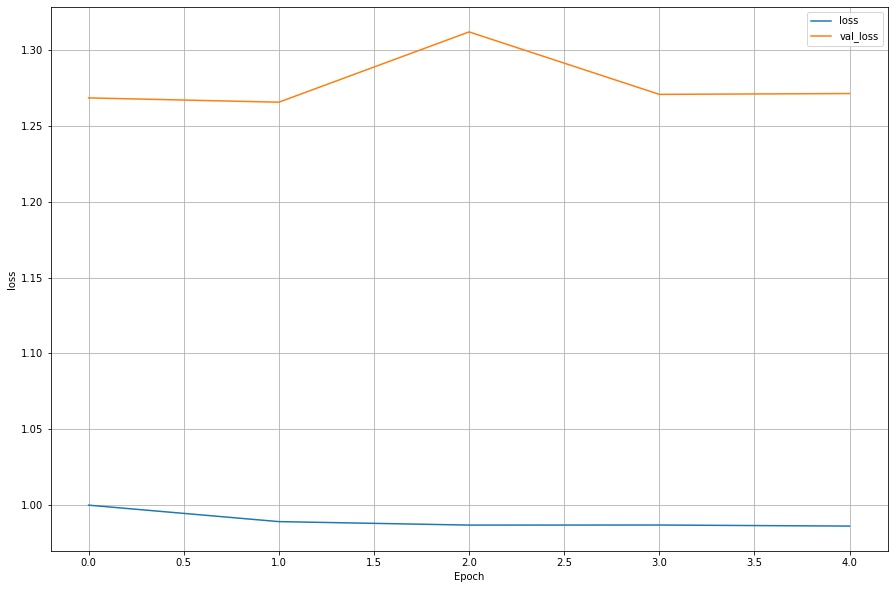

In [91]:
plot_loss(history, 'loss')

In [92]:
lstm_bidi_single.save_model("l_b_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_b_s.model\assets


### GRU single shot

In [93]:
gru_model_single = tf.keras.models.Sequential([

    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])

In [94]:
gru_single = MyModel(gru_model_single)

In [95]:
history = gru_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 8s 5ms/step - loss: 1.0123 - mean_absolute_error: 0.4852 - val_loss: 1.3338 - val_mean_absolute_error: 0.6536
Epoch 2/120
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0072 - mean_absolute_error: 0.4898 - val_loss: 1.2848 - val_mean_absolute_error: 0.5871
Epoch 3/120
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0032 - mean_absolute_error: 0.4838 - val_loss: 1.2850 - val_mean_absolute_error: 0.6047
Epoch 4/120
1318/1318 [==============================] - 6s 5ms/step - loss: 1.0017 - mean_absolute_error: 0.4796 - val_loss: 1.3241 - val_mean_absolute_error: 0.6432
Epoch 5/120
1318/1318 [==============================] - 7s 5ms/step - loss: 1.0056 - mean_absolute_error: 0.4761 - val_loss: 1.2871 - val_mean_absolute_error: 0.5760


In [96]:
single_val_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 1s 2ms/step - loss: 1.2848 - mean_absolute_error: 0.5871
Loss: 1.2847706079483032 MAE: 0.5871485471725464
188/188 [==============================] - 0s 2ms/step - loss: 0.9729 - mean_absolute_error: 0.4696
Loss: 0.9729400873184204 MAE: 0.4695856273174286


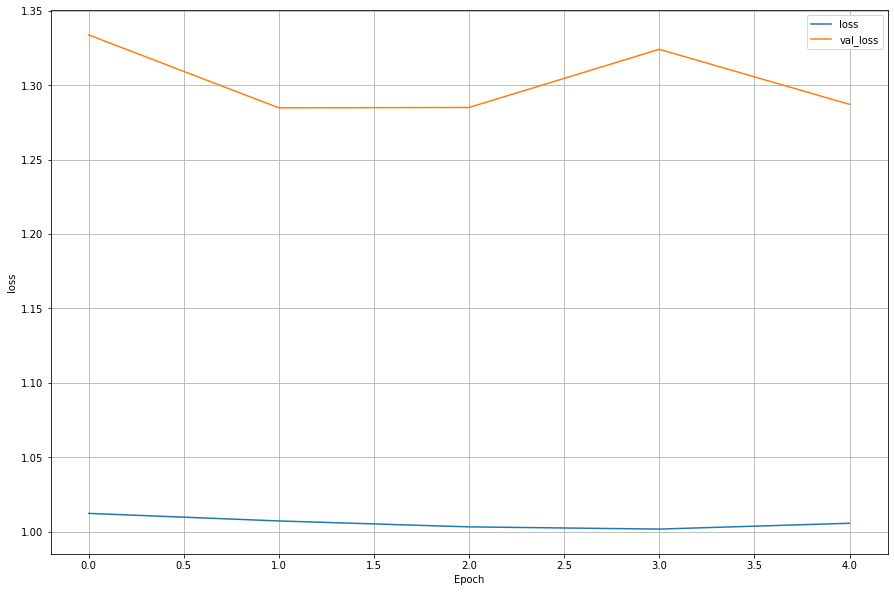

In [97]:
plot_loss(history, 'loss')

In [98]:
gru_single.save_model("gru_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru_s.model\assets


### GRU Bidirectional single shot

In [99]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act)),
    #tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [100]:
gru_bidi_single = MyModel(gru_model_bidirectional_single)

In [101]:
history = gru_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 15s 9ms/step - loss: 1.0243 - mean_absolute_error: 0.5019 - val_loss: 1.2883 - val_mean_absolute_error: 0.6075
Epoch 2/120
1318/1318 [==============================] - 11s 8ms/step - loss: 1.0041 - mean_absolute_error: 0.4903 - val_loss: 1.3053 - val_mean_absolute_error: 0.6385
Epoch 3/120
1318/1318 [==============================] - 11s 9ms/step - loss: 1.0045 - mean_absolute_error: 0.4873 - val_loss: 1.2878 - val_mean_absolute_error: 0.6004
Epoch 4/120
1318/1318 [==============================] - 11s 8ms/step - loss: 1.0071 - mean_absolute_error: 0.4892 - val_loss: 1.3151 - val_mean_absolute_error: 0.6398
Epoch 5/120
1318/1318 [==============================] - 11s 8ms/step - loss: 1.0075 - mean_absolute_error: 0.4921 - val_loss: 1.3052 - val_mean_absolute_error: 0.6290
Epoch 6/120
1318/1318 [==============================] - 11s 8ms/step - loss: 1.0021 - mean_absolute_error: 0.4861 - val_loss: 1.2768 - val_mean_absolute_error:

In [102]:
single_val_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 1s 4ms/step - loss: 1.2758 - mean_absolute_error: 0.5803
Loss: 1.2757747173309326 MAE: 0.5802761316299438
188/188 [==============================] - 1s 4ms/step - loss: 0.9650 - mean_absolute_error: 0.4583
Loss: 0.9650192260742188 MAE: 0.4582861065864563


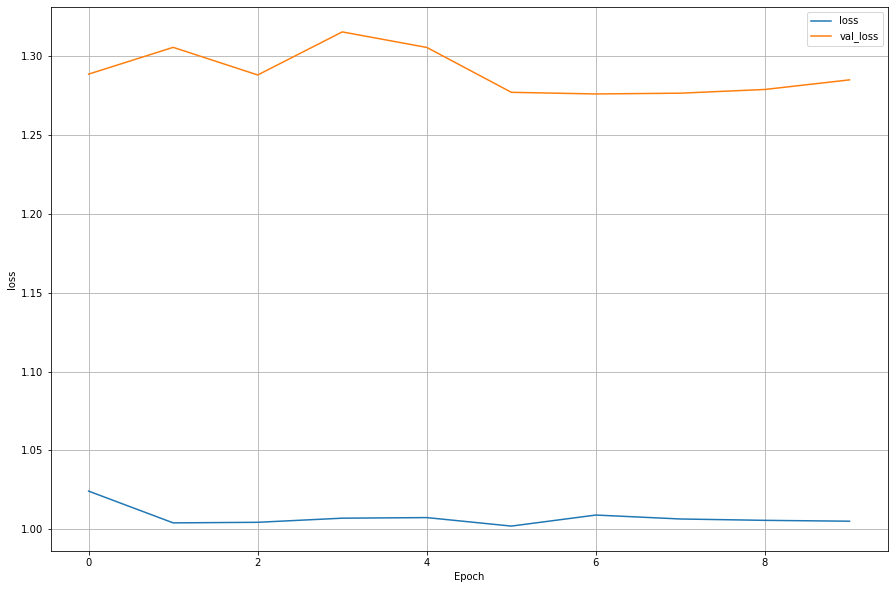

In [103]:
plot_loss(history, 'loss')

In [104]:
gru_bidi_single.save_model("g_b_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_b_s.model\assets


### Evaluating loaded models

In [140]:
path = "models_28_04_2021"

In [141]:
lstm = load_model("models_pct/"+path+"/lstm.model")
lstm_bidi = load_model("models_pct/"+path+"/l_bidi.model")
gru = load_model("models_pct/"+path+"/gru.model")
gru_bidi = load_model("models_pct/"+path+"/g_bidi.model")

## Single shot 
lstm_s = load_model("models_pct/"+path+"/lstm_s.model")
lstm_bidi_s = load_model("models_pct/"+path+"/l_b_s.model")
gru_s = load_model("models_pct/"+path+"/gru_s.model")
gru_bidi_s = load_model("models_pct/"+path+"/g_b_s.model")

In [142]:
loaded_model_lstm = MyModel(lstm)

In [143]:
loaded_model_lstm.eval_mod(wide_window_d.val, 0)

Loss: 1.2951608896255493 MAE: 0.5994835495948792


In [144]:
loaded_model_lstm.eval_mod(wide_window_d.test, 0)

Loss: 1.0116475820541382 MAE: 0.4808053970336914


In [145]:
loaded_model_lstm.eval_mod(wide_window_my.test, 0)

Loss: 2.6563637256622314 MAE: 0.8193917274475098


In [146]:
loaded_model_lstm_b = MyModel(lstm_bidi)

In [147]:
loaded_model_lstm_b.eval_mod(wide_window_d.val, 0)

Loss: 0.0606643445789814 MAE: 0.05007486045360565


In [148]:
loaded_model_lstm_b.eval_mod(wide_window_d.test, 0)

Loss: 0.042227644473314285 MAE: 0.04077136144042015


In [149]:
loaded_model_lstm_b.eval_mod(wide_window_my.test, 0)

Loss: 0.11850348114967346 MAE: 0.06790819019079208


In [150]:
loaded_model_gru = MyModel(gru)

In [151]:
loaded_model_gru.eval_mod(wide_window_d.val, 0)

Loss: 1.2729026079177856 MAE: 0.5909075140953064


In [152]:
loaded_model_gru.eval_mod(wide_window_d.test, 0)

Loss: 0.9655992388725281 MAE: 0.4709227681159973


In [153]:
loaded_model_gru.eval_mod(wide_window_my.test, 0)

Loss: 2.5999579429626465 MAE: 0.7713375091552734


In [154]:
loaded_model_gru_bidi = MyModel(gru_bidi)

In [155]:
loaded_model_gru_bidi.eval_mod(wide_window_d.val, 0)

Loss: 0.07136011868715286 MAE: 0.08051327615976334


In [156]:
loaded_model_gru_bidi.eval_mod(wide_window_d.test, 0)

Loss: 0.04836266115307808 MAE: 0.07081781327724457


In [157]:
loaded_model_gru_bidi.eval_mod(wide_window_my.test, 0)

Loss: 0.13230334222316742 MAE: 0.10603740811347961


#### Eval single

In [158]:
loaded_model_lstm_s = MyModel(lstm_s)

In [159]:
loaded_model_lstm_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2926894426345825 MAE: 0.5749314427375793


In [160]:
loaded_model_lstm_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9806920886039734 MAE: 0.44770801067352295


In [161]:
loaded_model_lstm_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.5703842639923096 MAE: 0.7030608057975769


In [162]:
lstm_s.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 32)            4736      
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 32)            8320      
_________________________________________________________________
dense_4 (Dense)              (None, 24, 1)             33        
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [163]:
loaded_model_lstm_b_s = MyModel(lstm_bidi_s)

In [164]:
loaded_model_lstm_b_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2656676769256592 MAE: 0.58575040102005


In [165]:
loaded_model_lstm_b_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9576230645179749 MAE: 0.4608459174633026


In [166]:
loaded_model_lstm_b_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.5883684158325195 MAE: 0.7427864074707031


In [167]:
loaded_model_gru_s = MyModel(gru_s)

In [168]:
loaded_model_gru_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2847708463668823 MAE: 0.5871483683586121


In [169]:
loaded_model_gru_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9729402661323547 MAE: 0.46958595514297485


In [170]:
loaded_model_gru_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.5729146003723145 MAE: 0.7277155518531799


In [171]:
loaded_model_gru_b_s = MyModel(gru_bidi_s)

In [172]:
loaded_model_gru_b_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2757744789123535 MAE: 0.5802761912345886


In [173]:
loaded_model_gru_b_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9650195240974426 MAE: 0.45828601717948914


In [174]:
loaded_model_gru_b_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.574856758117676 MAE: 0.7251095175743103


In [180]:
loaded_model_gru_b_s.eval_mod(wide_window_my_single.train, 0)

Loss: 0.5250693559646606 MAE: 0.30975669622421265
